# Minodes Recruitment Challenge 

Rameez Ragheb

23 July 2018

## Introduction                                                                                  

In this project we want to predict location of different smartphones in a Mall based on their WiFi probe request. Signal strength coming from mobilephones is collected by Wifi Routers ('nodes'). A probe request from a smartphone is given to us as a dictionary {'node_id: 'signal_strength, ...}, called a 'fingerprint', along with a 'zone' in the Mall from where the probe request generated.

Our aim is to classify fingerprints to their respective zones.

Minodes provided us with ~340000 unique fingerprints labelled into 449 unique zones. Lets start!

### Data preparation

Cleaning up the data, checking for missing values, duplicates and any inconsistencies and then bringing it to a form which can be used for further analysis.

In [47]:
import multiprocessing
pool = multiprocessing.Pool(processes = 50)

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
#read file
df = pd.read_csv('fingerprints_gt_ver3.csv', header = 0, sep = ',', parse_dates=True)
df.head()

,fr_observation_time,fr_values,fr_mac_address_id,zo_name
0,2015-12-08 10:00:13,"{'12': '-69', '33': '-61', '128': '-68', '276'...",2002427,Zone 355
1,2015-12-08 10:00:13,"{'9': '-83', '13': '-67', '33': '-62', '101': ...",3192369,Zone 355
2,2015-12-08 10:00:14,"{'9': '-83', '10': '-77', '11': '-85', '12': '...",2002427,Zone 355
3,2015-12-08 10:00:14,"{'9': '-86', '10': '-83', '11': '-87', '12': '...",3192369,Zone 355
4,2015-12-08 10:00:15,"{'10': '-76', '11': '-86', '12': '-65', '13': ...",480806,Zone 355


In [70]:
# Checking for any missing values in the DataFrame. Returns True if we have some missing value, False otherwise.
df.isnull().values.any()

False

In [73]:
#Next, we identify the duplicates in the dataset

#duplicate_indicies
duplicate_indicies = df.duplicated(keep=False)

duplicate_documents_in_df = df[duplicate_indicies]
print( "There are " + str(len(duplicate_documents_in_df)) + " duplicate entries in the dataset")


There are 0 duplicate entries in the dataset


In [52]:
#Changing 'zo_name' from string to integer
df['zo_name'] = df['zo_name'].map(lambda x: x.lstrip('Zone'))
df.head()
df.zo_name = pd.to_numeric(df.zo_name)

In [53]:
# Changing fingerprint column to a dataframe containing 261 columns each representing a single node.
import ast
temp_list = df.fr_values.tolist()
fr_list = []                         # stores fingerprints as dictionaries
for i in temp_list:
    d = ast.literal_eval(i)          # changes a dict like string to a dictionary
    fr_list.append(d)

fr_values = pd.DataFrame.from_records(fr_list)  # the new dataframe containing 261 columns each representing a single node


In [14]:
# Checks if we have any empty fingerprints. If True, each fingerprint contains atleast some node :signal pair
fr_values.all().all()

True

In [54]:
# Assigning -100 signal strength to nodes not present in a fingerprint
fr_values= fr_values.fillna(-100)

fr_values.head()

,1,10,101,102,103,104,105,107,109,11,...,89,9,90,91,92,93,94,97,98,99
0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100
1,-100,-100,-64,-100,-100,-100,-100,-100,-100,-100,...,-100,-83,-100,-100,-100,-100,-100,-100,-100,-100
2,-100,-77,-69,-71,-100,-100,-100,-100,-100,-85,...,-100,-83,-100,-100,-100,-100,-100,-100,-79,-74
3,-100,-83,-65,-100,-100,-100,-100,-100,-100,-87,...,-100,-86,-100,-100,-100,-100,-100,-100,-100,-80
4,-100,-76,-65,-100,-100,-100,-100,-100,-100,-86,...,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100


In [71]:
# Check: All the signal values should be between[-100, 0] in fr_values

fr_values = fr_values.astype(int)
def count_values_in_range(series, range_min, range_max):
    # Returns the number of values in a series which are between range_min and range_max
    # "between" returns a boolean Series equivalent to left <= series <= right.
    
    return series.between(left=range_min, right=range_max).sum()

    


range_min, range_max = -100, 0

# Apply count_values_in_range to each row of fr_values
outlier = fr_values.apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)

if outlier.value_counts().max() == len(df):
    print("The signal strength at each node in all fingerprints is within [-100, 0] range")
else:
    print(str(len(df) - outlier.value_counts().max()) + " wrong fingerprints in the data set")

The signal strength at each node in all fingerprints is within [-100, 0] range


### Some Statistics and Exploratory Analysis

Statistics provided by Minodes:

343449 unique fingerprints (rows in df)

19 unique mac address ids

449 unique zones (classes)

261 unique nodes (training features)

In [55]:
fr_values.shape

(343449, 261)

In [56]:
df.zo_name.shape

(343449,)

fr_values is the dataframe containing our X_labels (features). df.zo_name is our y_label (classes).

In [57]:
# Checking frequency of different zones in our dataset
df.zo_name.value_counts()

548    1799
409    1701
410    1640
556    1592
74     1590
414    1580
546    1568
33     1305
492    1264
185    1217
11     1216
351    1211
184    1211
13     1206
178    1199
6      1198
190    1198
14     1193
116    1189
92     1189
183    1188
93     1180
436    1179
109    1178
278    1176
115    1170
111    1169
15     1169
16     1168
91     1165
       ... 
257     198
451     193
318     177
205     177
321     176
63      166
401     165
213     155
517     140
216     124
281     116
209     115
122     114
307     104
259      98
138      85
140      78
228      76
8        59
61       48
523      47
313      46
3        44
289      42
320      36
422      31
265      13
1         4
260       4
258       3
Name: zo_name, Length: 449, dtype: int64

We see that there is class imbalance in our dataset. Some of the zones appear in less than 10 rows while some others appear in more than 1500 rows. This will be a problem for our classification model as it will overfit the classes that appear often and ignore the classes which occur infrequently.

Next we explore some other aspects of our dataset not directly related to the classification problem.

Define 'length' of a fingerprint as the length of the corresponding dictionary i.e. number of nodes with signal strength > -100 in the fingerprint.
We want to study the length of fingerprints produced by different mac ids. This can tell us whether certain mac ids perform 'better' than others i.e. are generally detected by more nodes.

Text(0,0.5,'fingerprint length')

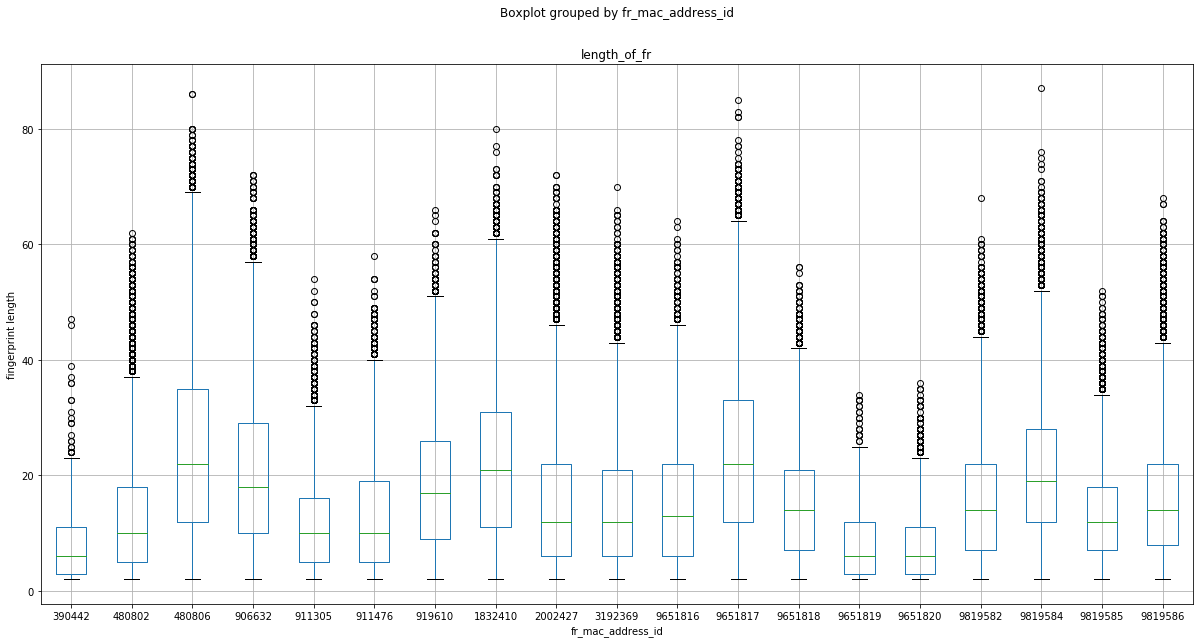

In [59]:
# Create a new dataframe 'pilot' from fr_list (list of dictionaries representing fingerprints) 
fr_series = pd.Series(fr_list)
pilot = pd.DataFrame()  
pilot['fr_list'] = fr_series.values
# Add corresponding mac_address_id which produced the fingerprint
pilot['fr_mac_address_id'] = df['fr_mac_address_id']
type(pilot.fr_list[0])

#Add a third column 'length_of_fr' to pilot which contains the length of fingerprint
for i in range(0, len(pilot)):
    pilot.loc[i, 'length_of_fr'] = len(pilot.loc[i, 'fr_list'])

#Boxplots for fingerprint lengths grouped by mac_address_id
fig, ax = plt.subplots(figsize=(20, 10))
pilot.boxplot(column='length_of_fr', by='fr_mac_address_id', ax = ax)
ax.set_xlabel("fr_mac_address_id")
ax.set_ylabel("fingerprint length")

The distributions of fingerprint length for all mac ids are very similar, so we can conclude that all the mac ids have similar wifi range.

Next, we want to track the movement of different mac ids over time. This can give us valuable insight into consumer behavior. For example we can learn about the following queries. What zones do people start their journey from(which can tell us about possible entrances to the mall)? At what time do we have most activity? What zones do people spend most of their time in? Do people follow a crowd?

Text(0,0.5,'Zone codes')

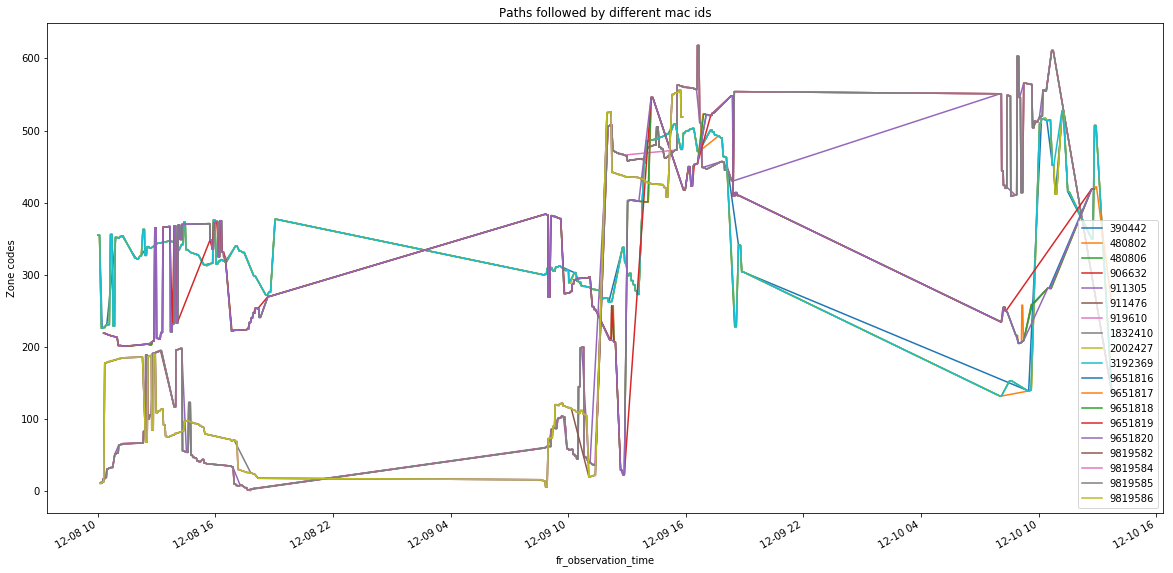

In [61]:
# Generating line plots for the path followed by each mac_id over time
df = df.set_index(pd.DatetimeIndex(df['fr_observation_time']))
fig, ax = plt.subplots(figsize=(20, 10))
df[['fr_mac_address_id', 'zo_name']].groupby('fr_mac_address_id')['zo_name'].plot(ax = ax,legend=True, title = 'Paths followed by different mac ids')
ax.set_xlabel("fr_observation_time")
ax.set_ylabel("Zone codes")

It looks like at around 14:00 on the second day, our experimenters decided that they should move to zones with zone_name above 400.

Returning to the main task, we extract the correlation matrix of nodes to check for collinearity in data.

Note: Collinearity implies correlation, thus, No correlation implies noncollinearity

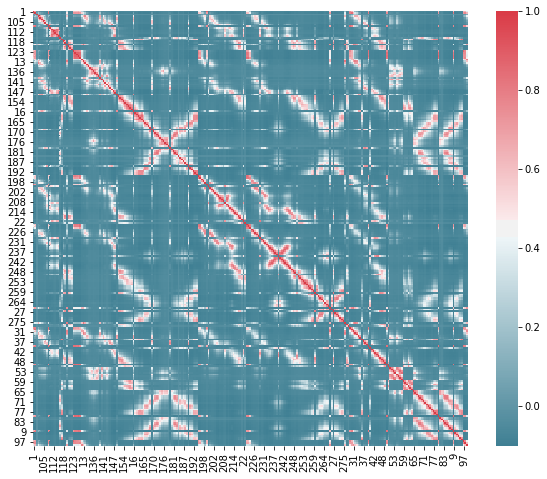

In [12]:
fr_values = fr_values.astype(int)

corr = fr_values.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

The heat map above represents the correlation matrix, with red implying higher correlation. The bright red spots other than the diagonal indicate that we might have high correlation among certain nodes. This can be problematic in models which assume no correlation among the independent variables.

One way to avoid it is by applying Principal Component Analysis (PCA), which transforms the data to orthogonal 'principle components' thus removing correlation from the data.

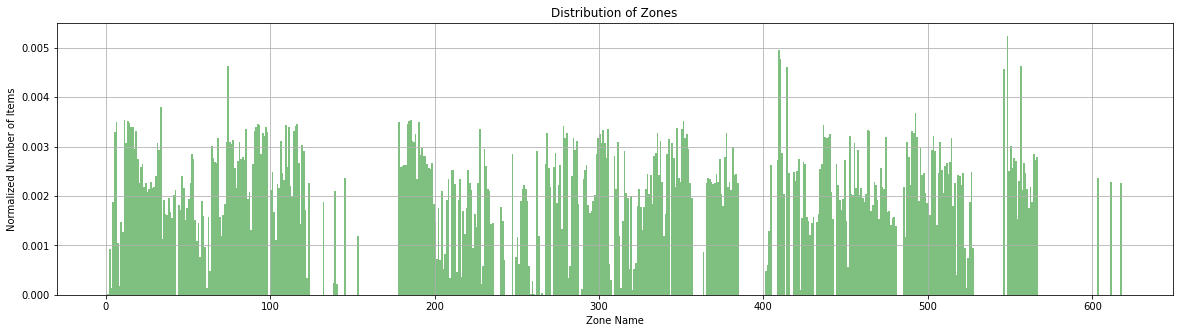

In [8]:
# Overview about Zone names distribution
x = np.array(df.zo_name)
num_bins = max(x)-min(x)

plt.figure(figsize = (20,5))
# the histogram of the data
plt.hist(x, num_bins, normed=1, facecolor='green', alpha=0.5)
plt.title('Distribution of Zones')
plt.xlabel("Zone Name")
plt.ylabel("Normalized Number of Items")
plt.grid(1)

## Model Fitting

Now we split the dataset in a training and test set while keeping the distribution of zone codes (stratified sampling).

We choose stratified sampling over cross validation technique as class imbalance in our data set can result in certain classes not appearing in the training set when produced randomly using cross validation and thus would not be available for the model to train on.

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
# we use 80% as training data and 20% as test data
sss = StratifiedShuffleSplit(test_size=0.20, random_state=0)

for train_index, test_index in sss.split(fr_values, df.zo_name):
    #print("TRAIN:", train_index, "TEST:", test_index)
    training_data, testing_data = train_index, test_index

In [11]:
# check split ratios
round(100/len(x)*len(training_data)), round(100/len(x)*len(testing_data))

(80, 20)

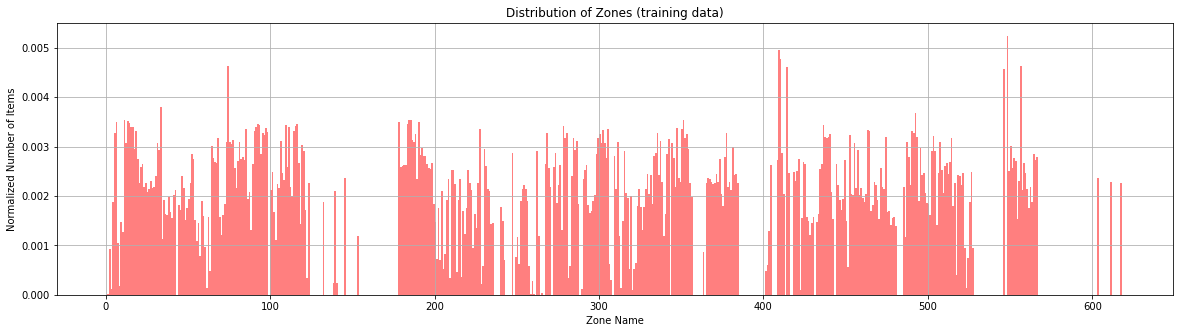

In [12]:
# Cross check: plot resampled training zone distribution
plt.figure(figsize = (20,5))
# the histogram of the data
plt.hist(x[training_data], num_bins, normed=1, facecolor='red', alpha=0.5)
plt.title('Distribution of Zones (training data)')
plt.xlabel("Zone Name")
plt.ylabel("Normalized Number of Items")
plt.grid(1)

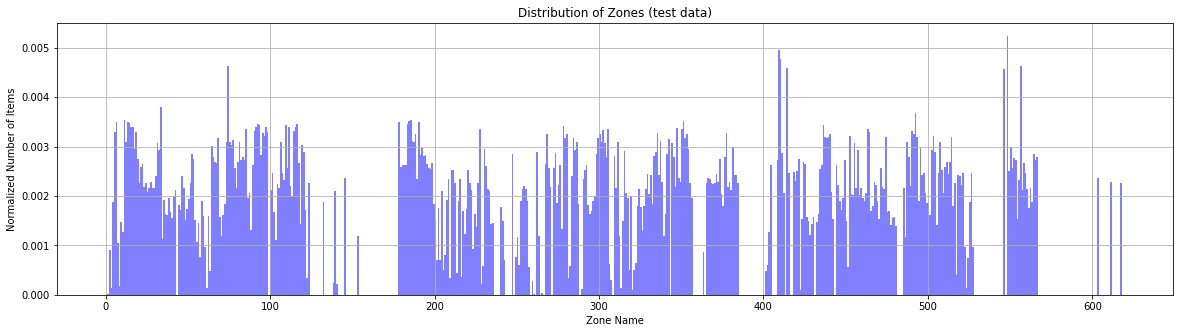

In [13]:
# Cross check: plot resampled test zone distribution
plt.figure(figsize = (20,5))
# the histogram of the data
plt.hist(x[testing_data], num_bins, normed=1, facecolor='blue', alpha=0.5)
plt.title('Distribution of Zones (test data)')
plt.xlabel("Zone Name")
plt.ylabel("Normalized Number of Items")
plt.grid(1)

In [14]:
X_train = fr_values.iloc[training_data]
X_test = fr_values.iloc[testing_data]
y_train = df.zo_name.iloc[training_data]
y_test = df.zo_name.iloc[testing_data]
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(274759, 261) (274759,)
(68690, 261) (68690,)


Next we tried selecting the best features that independently explain the zone distribution via univariate analysis.
The best 250 nodes were selected using Chi2 scores and stored as X_KBest. 

The hope was to reduce some noise from the data to enhance performance of models but X_KBest produced worst results. This is understandable by the nature of our problem. A fingerprint i.e. the set of nodes it contains and their corresponding signals defines the zone and no single node independently can characterize it. Neverthelss, we include the univariate analysis code for the sake of completion.

The results of models applied on X_KBest are not included in the file.

In [64]:
#Feature Selection to reduce dimensionality
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
Input_X = X_train+100               #Translating X_train to a positive set since SelectKBest only works for positive inputs
Select = SelectKBest(chi2, k=250)
X_KBest = Select.fit_transform(Input_X, y_train)
X_KBest.shape

(274759, 250)

This is how our model pipeline proceeds. We perform Scaling and then PCA on our training set followed with training different models and their hyperparameter optimization on raw/scaled/scaled_PCA_transformed training data. Thus no test data is used in the training of the models.

We assess the performance of our models on the raw/scaled/scaled_PCA_transformed test set.

Scaling: Although each node has the same range of signal strength [-100, 0], some models perform better and converge faster when the data is scaled to a smaller range.

PCA: Principal component analysis transforms the feature set to a new set of linearly uncorrelated orthogonal principal components such that the maximum variance in the data lands on the first principal component, the second component has the highest variance possible such that it is orthogonal to the first and so on. Thus PCA provides a better 'view' at the data and some models, sensitive to collinearity, perform better.

In [15]:
# Scaling
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(X_train)  
X_scaled_train = scaler.transform(X_train)  
X_scaled_test = scaler.transform(X_test)

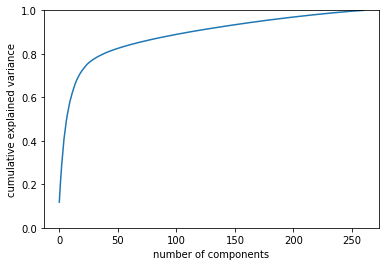

In [31]:
# Fit PCA to X_train
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
plt.xlabel('number of components') 
plt.ylabel('cumulative explained variance');
plt.ylim(ymax=1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

The graph above shows cumulative variance explained by the number of components. We can see that more than 80% of the variance in the data can be described by the first 50 principal components out of the 261.

In [32]:
ratio = np.sum(pca.explained_variance_ratio_[0: 239])
print("The explained variance ratio for the first 240 principal components is " + str(round(ratio*100, 2)) + "%")

The explained variance ratio for the first 240 principal components is 99.07%


Sometimes dimensionality reduction results in better models as it can help against overfitting. Thus we will keep two training sets to study this happening. 

Since the first 240 principal components explain more than 99% of the variance, we can assume that not much information is lost by reducing our data to 240 dimensions 

In [66]:
# Transform  X_scaled_train and X_scaled_test using PCA
X_PCA_train = pca.transform(X_train)
X_PCA_test = pca.transform(X_test)
scaler.fit(X_PCA_train)  
X_PCA_scaled_train = scaler.transform(X_PCA_train)  
X_PCA_scaled_test = scaler.transform(X_PCA_test)

print(X_PCA_scaled_train.shape, X_PCA_scaled_test.shape)

# Transform  and reduce X_scaled_train and X_scaled_test using PCA to 200 principal components

pcared = PCA(n_components = 240)
pcared.fit(X_train)
X_PCA_red_train = pcared.transform(X_train)
X_PCA_red_test = pcared.transform(X_test)
scaler.fit(X_PCA_red_train)  
X_PCA_red_scaled_train = scaler.transform(X_PCA_red_train)  
X_PCA_red_scaled_test = scaler.transform(X_PCA_red_test)

print(X_PCA_red_scaled_train.shape, X_PCA_red_scaled_test.shape)


(274759, 261) (68690, 261)
(274759, 240) (68690, 240)


In [72]:
# Scores for Machine Learning Models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


We start fitting and scoring different models on our data.

### Linear Discriminant Analysis (LDA)

The first model we train is Linear Discriminant Analysis (LDA). It is one of the basic classifier models so it makes sense to start with it.

The parameters for LDA were tuned using brute force since there are not many parameters to begin with and LDA showed little sensitivity to change of parameters.

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


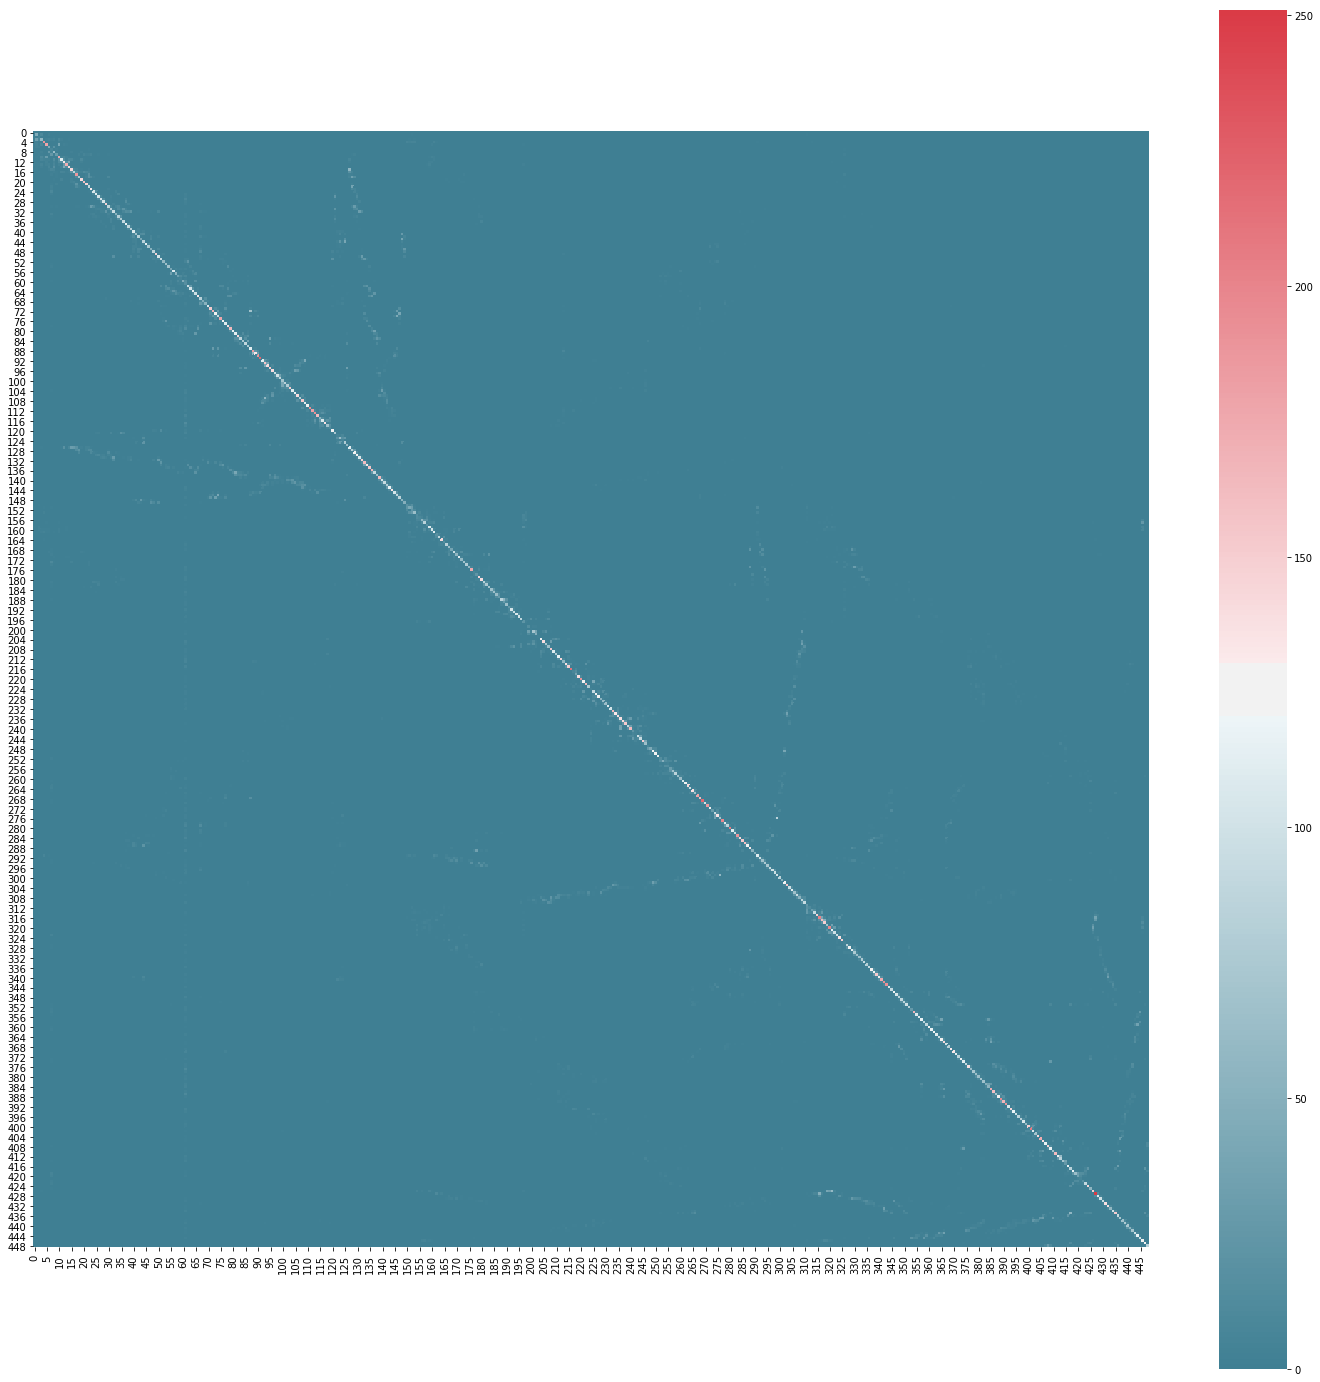

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.48      0.73      0.58        63
          3       0.16      0.56      0.24         9
          4       0.52      0.45      0.48       129
          5       0.89      0.85      0.87       226
          6       0.80      0.75      0.77       240
          7       0.44      0.64      0.52        72
          8       0.04      0.58      0.08        12
          9       0.44      0.61      0.51       101
         10       0.77      0.34      0.48        87
         11       0.65      0.72      0.68       243
         12       0.72      0.52      0.61       212
         13       0.53      0.56      0.54       241
         14       0.80      0.72      0.75       239
         15       0.67      0.59      0.63       234
         16       0.65      0.62      0.63       234
         17       0.63      0.42      0.51       203
         18       0.65      0.82      0.73   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(solver= 'lsqr', shrinkage='auto', tol = 1.0e-10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

For a good predictor the confusion matrix should contain more values on the diagonal entries. The heat map of the confusion matrix for LDA shows that indeed we have more entries on the diagonal (red and white) and less entries (blue) off the diagonal and the diagonal is easily distinguishable from the rest of the matrix.

A good predictor model would have the diagonal more red than white. This is not the case here.

Also note the white spots off the diagonal which is troublesome.

The precision, recall and f1 scores for LDA are respectively 0.67, 0.65 and 0.65.

A score of 1 is best and 0 the worst.

The warning at the end shows that some classes in y_test were completely missed by the model and donot appear in y_pred.

### Random Forest Classifier

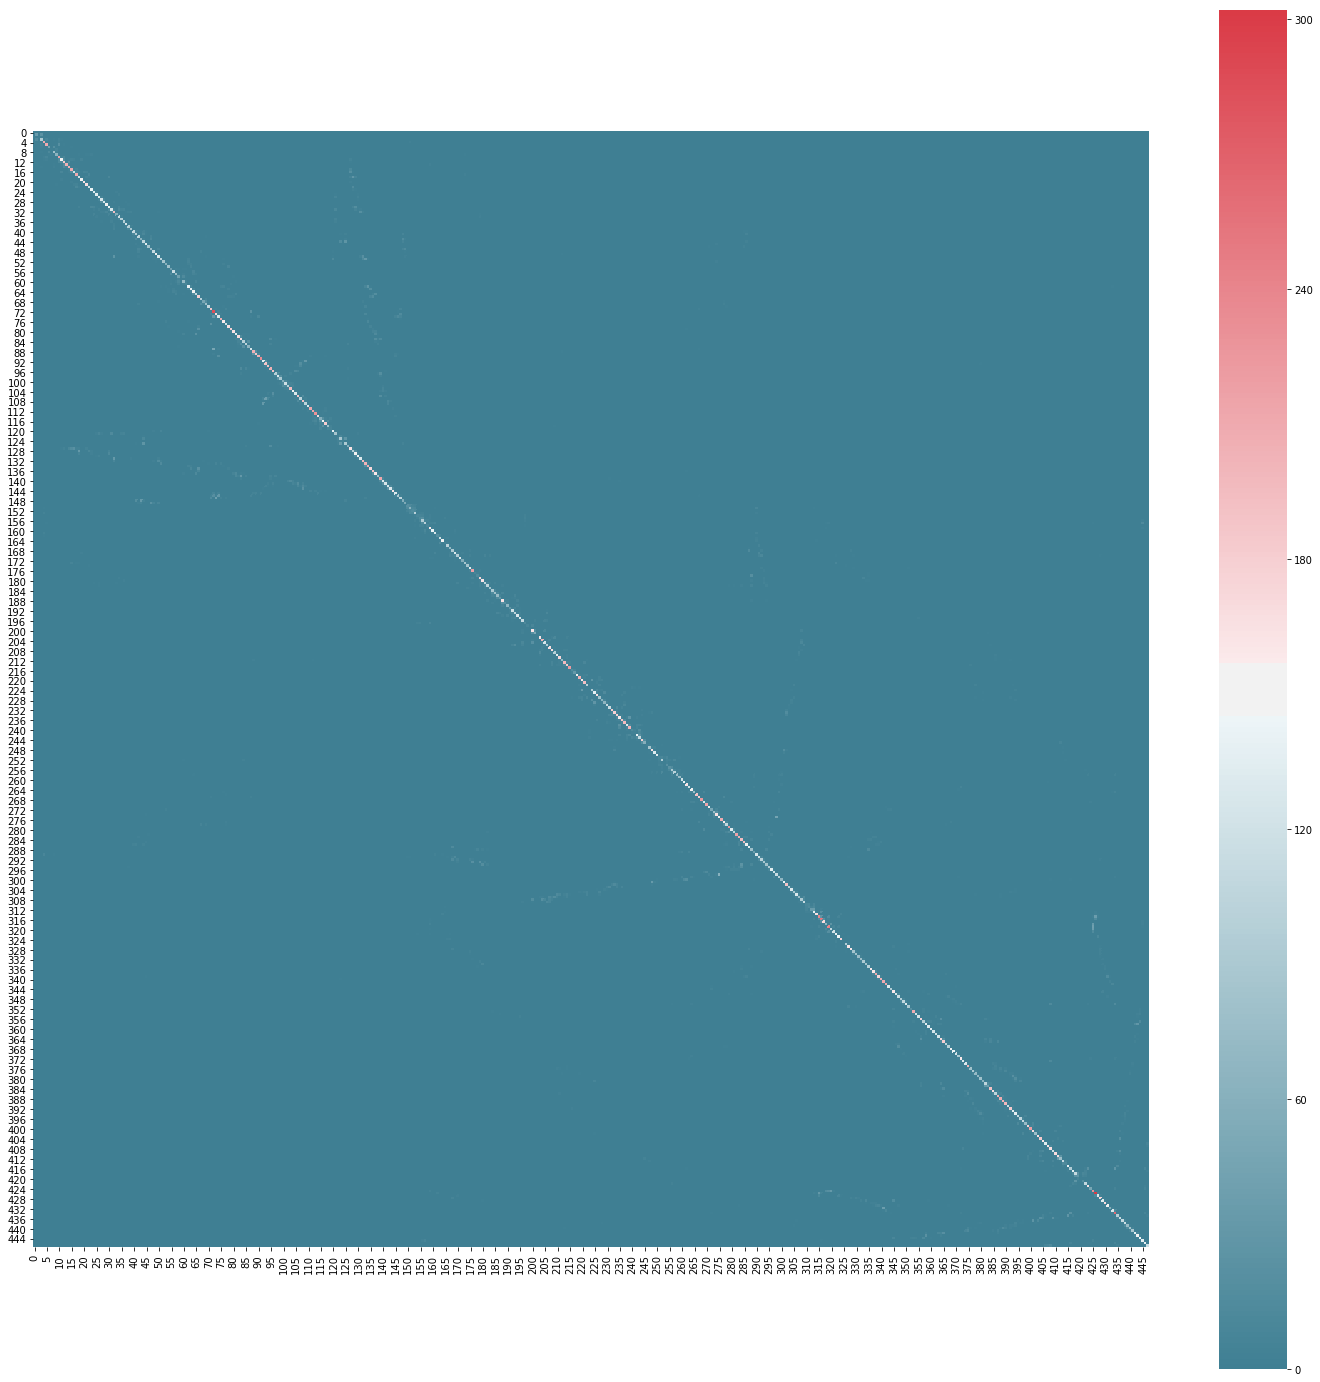

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.62      0.56      0.59        63
          3       0.33      0.11      0.17         9
          4       0.64      0.71      0.67       129
          5       0.87      0.94      0.90       226
          6       0.90      0.87      0.89       240
          7       0.66      0.62      0.64        72
          8       0.22      0.17      0.19        12
          9       0.70      0.79      0.74       101
         10       0.75      0.74      0.74        87
         11       0.79      0.88      0.84       243
         12       0.79      0.73      0.75       212
         13       0.75      0.78      0.76       241
         14       0.93      0.86      0.89       239
         15       0.82      0.87      0.84       234
         16       0.79      0.90      0.84       234
         17       0.76      0.59      0.66       203
         18       0.83      0.92      0.87   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# RandomForest Classifier on X_train
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs = 50)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

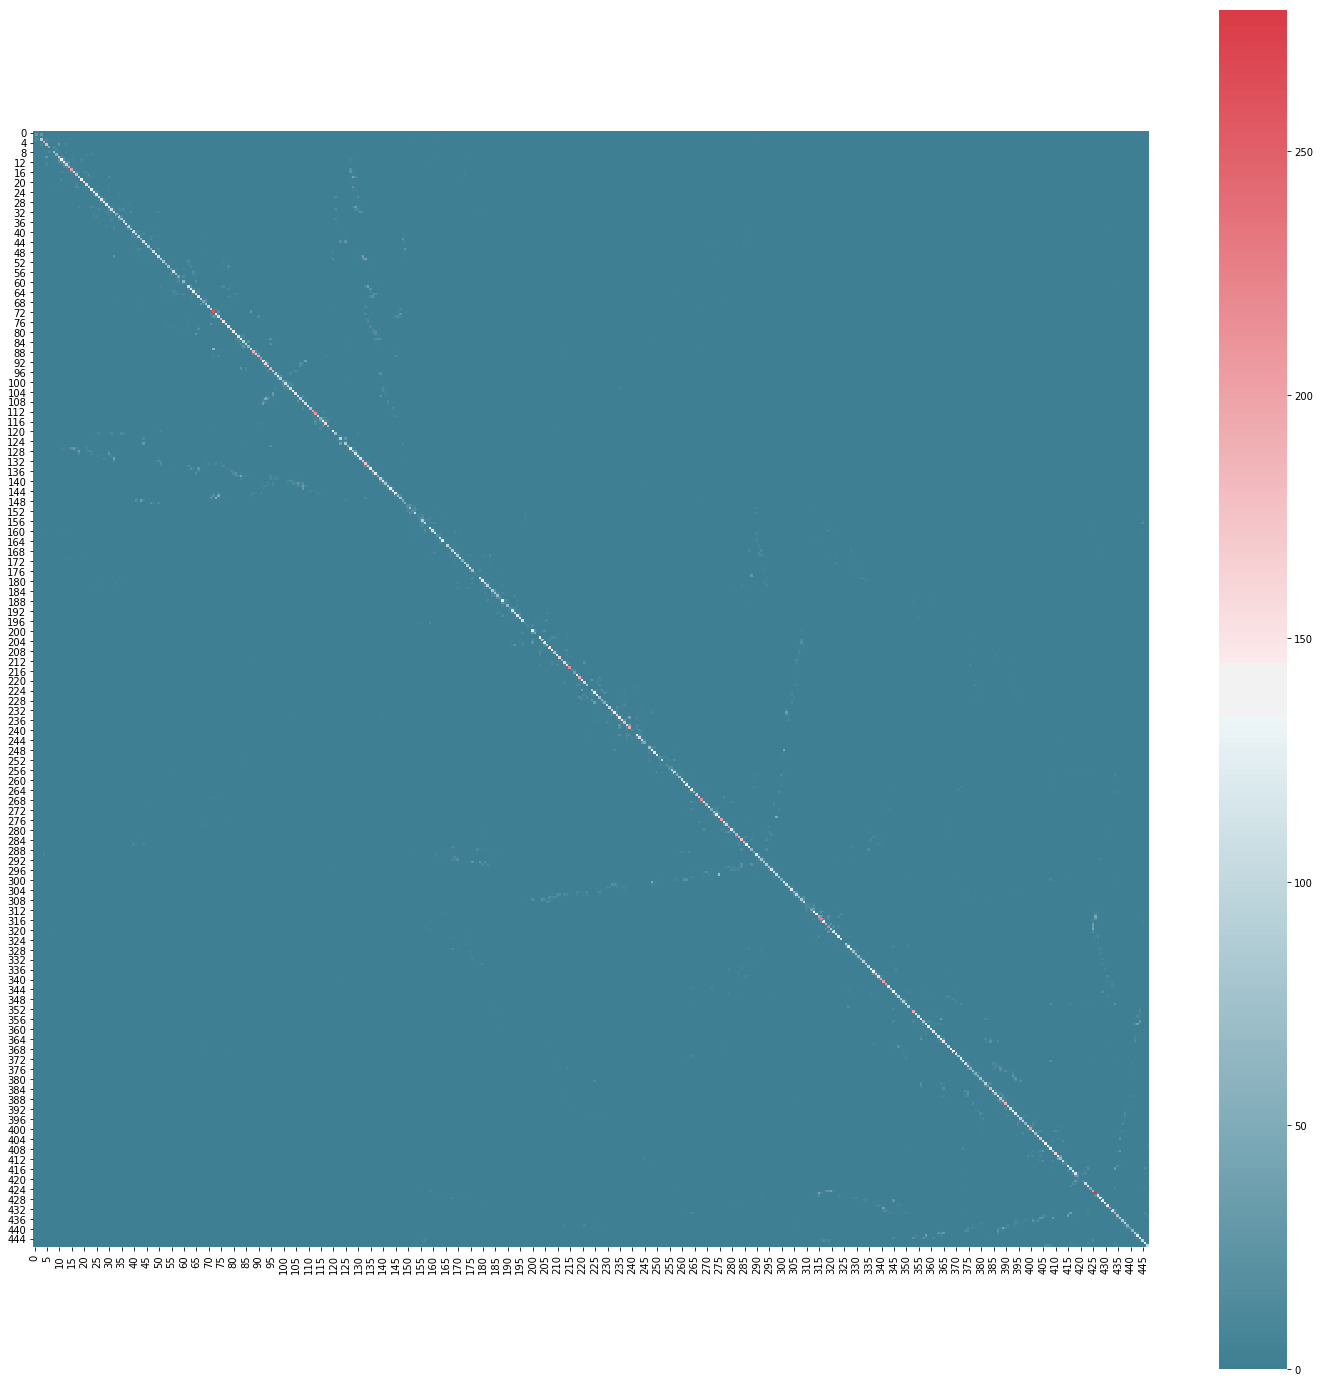

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.59      0.48      0.53        63
          3       0.33      0.11      0.17         9
          4       0.62      0.69      0.65       129
          5       0.90      0.91      0.91       226
          6       0.76      0.79      0.77       240
          7       0.71      0.71      0.71        72
          8       0.22      0.17      0.19        12
          9       0.64      0.69      0.66       101
         10       0.72      0.66      0.69        87
         11       0.69      0.76      0.72       243
         12       0.69      0.65      0.67       212
         13       0.67      0.63      0.65       241
         14       0.77      0.74      0.76       239
         15       0.78      0.82      0.80       234
         16       0.79      0.87      0.83       234
         17       0.66      0.52      0.58       203
         18       0.81      0.87      0.84   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# RandomForest Classifier on X_PCA_scaled_train

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs = 50)
clf.fit(X_PCA_scaled_train, y_train)
y_pred = clf.predict(X_PCA_scaled_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

RandomForest performed better than LDA in all scores. Moreover, RandomForest performed better on raw training data and the performance went down on PCA transformed data.

Furthermore, note that some of the white spots off the diagonal present in heatmap of LDA's confusion matrix are now gone with RandomForest.

Parameter Tuning: Since RandomForest is meant to have fully grown trees in its structure to reduce bias, all the parameters are set by default to grow the trees to maximum depth. The only parameter we tuned was n_estimators (number of trees). We can achieve better results with more trees, but the learning rate is very low and it is not time efficient.

### Stochastic Gradient Descent (SGD)

In [29]:
# Stochastic Gradient Descent on X_train

from sklearn import linear_model
clf = linear_model.SGDClassifier(loss = 'log', class_weight = 'balanced', max_iter = 20, n_jobs = 50, alpha = 0.00001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.00      0.00      0.00        63
          3       0.00      0.00      0.00         9
          4       0.00      0.00      0.00       129
          5       0.94      0.61      0.74       226
          6       0.64      0.66      0.65       240
          7       0.17      0.85      0.29        72
          8       0.00      0.00      0.00        12
          9       0.00      0.00      0.00       101
         10       0.50      0.05      0.08        87
         11       1.00      0.06      0.11       243
         12       0.62      0.57      0.59       212
         13       0.75      0.32      0.45       241
         14       1.00      0.00      0.01       239
         15       0.00      0.00      0.00       234
         16       0.00      0.00      0.00       234
         17       0.00      0.00      0.00       203
         18       0.69      0.15      0.25   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


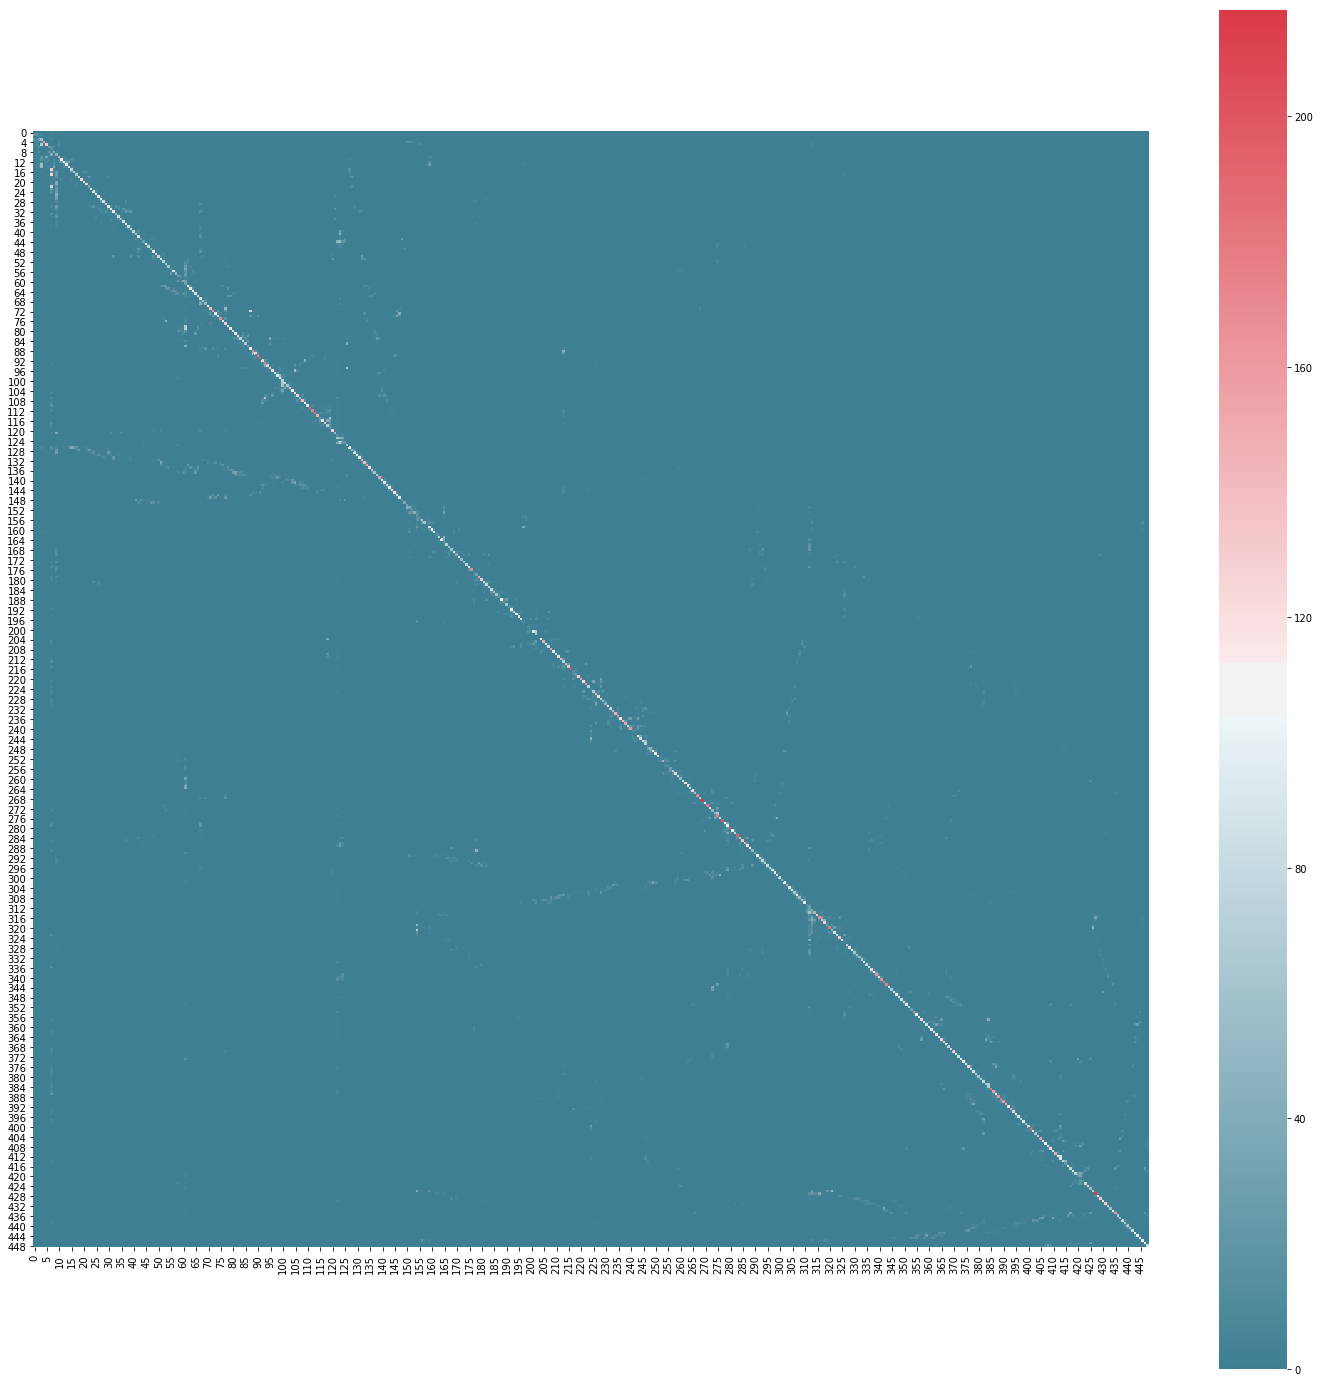

             precision    recall  f1-score   support

          1       0.02      1.00      0.04         1
          2       0.39      0.24      0.30        63
          3       0.06      0.78      0.11         9
          4       0.19      0.47      0.28       129
          5       0.92      0.70      0.80       226
          6       0.73      0.55      0.63       240
          7       0.35      0.33      0.34        72
          8       0.01      0.92      0.02        12
          9       0.33      0.45      0.38       101
         10       0.06      0.51      0.11        87
         11       0.81      0.65      0.72       243
         12       0.75      0.54      0.63       212
         13       0.73      0.41      0.52       241
         14       0.73      0.46      0.56       239
         15       0.62      0.41      0.50       234
         16       0.48      0.32      0.39       234
         17       0.68      0.33      0.44       203
         18       0.55      0.28      0.37   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
# Stochastic Gradient Descent on X_scaled_train

from sklearn import linear_model
clf = linear_model.SGDClassifier(loss = 'log', class_weight = 'balanced', max_iter = 20, n_jobs = 50, alpha = 0.00001)
clf.fit(X_scaled_train, y_train)
y_pred = clf.predict(X_scaled_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

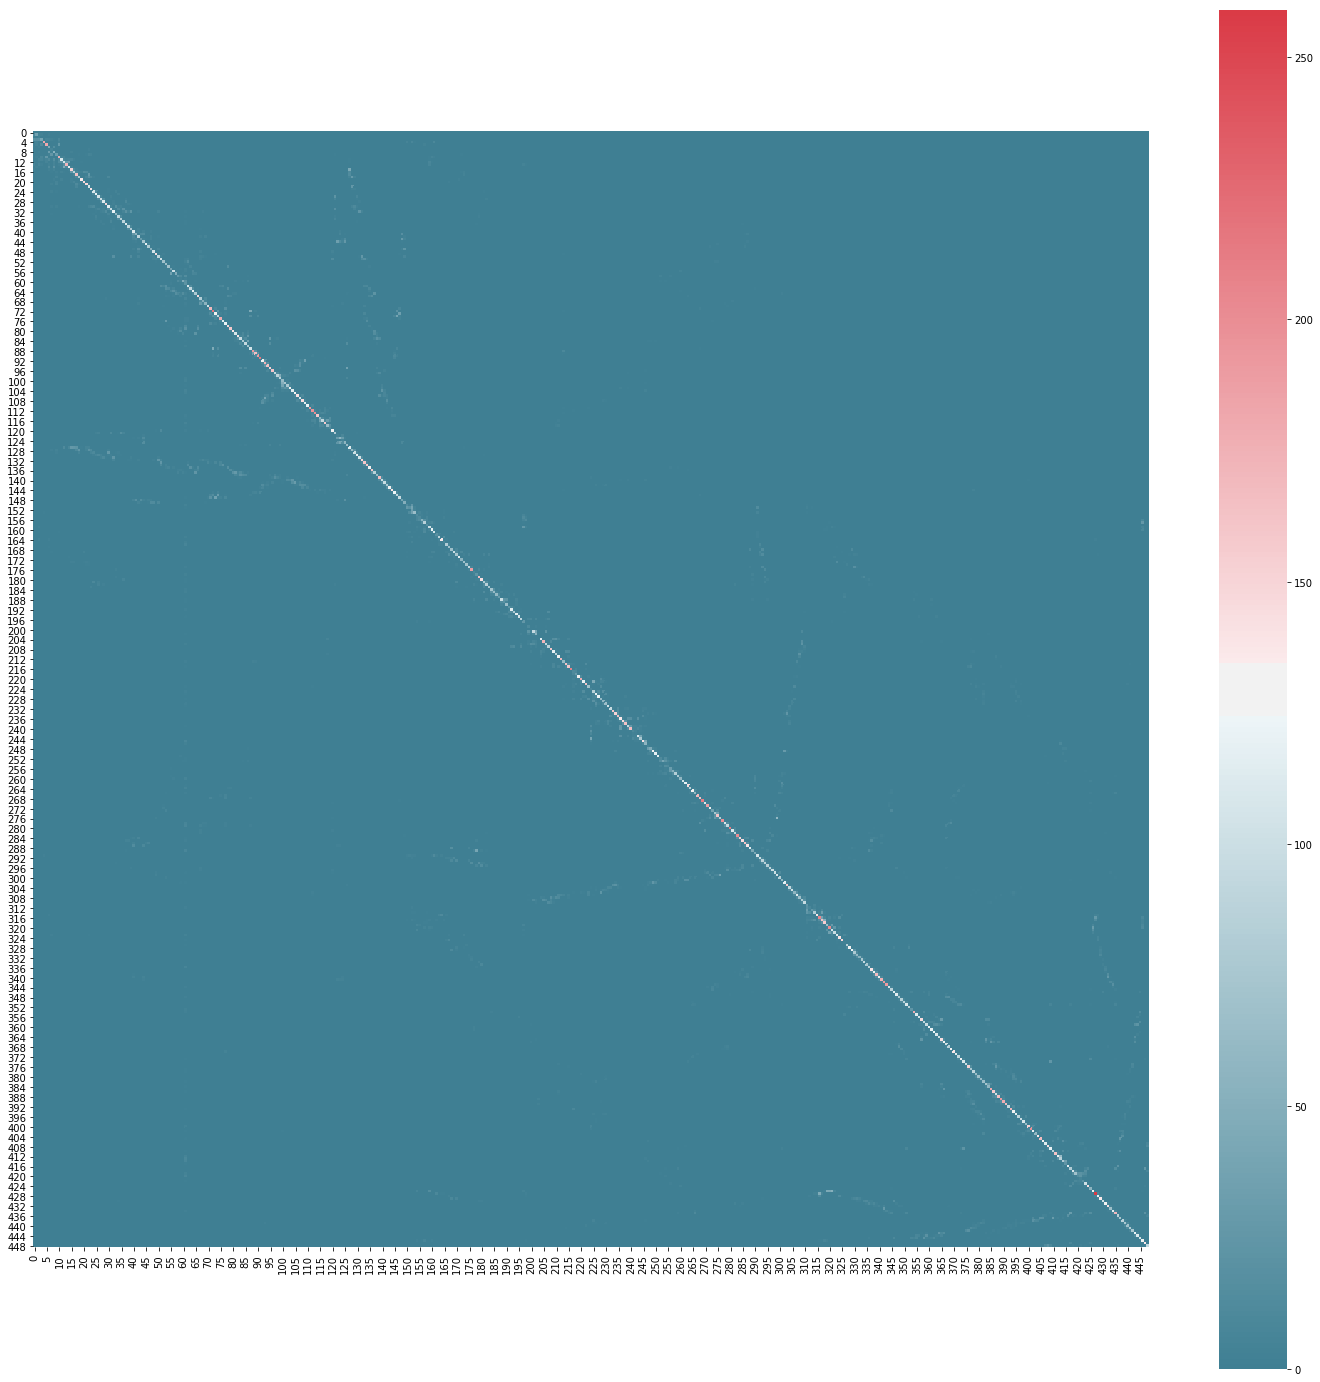

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.46      0.59      0.52        63
          3       0.05      0.44      0.09         9
          4       0.48      0.31      0.38       129
          5       0.93      0.81      0.87       226
          6       0.79      0.76      0.77       240
          7       0.32      0.67      0.44        72
          8       0.09      0.58      0.15        12
          9       0.40      0.52      0.46       101
         10       0.44      0.37      0.40        87
         11       0.71      0.72      0.72       243
         12       0.69      0.51      0.59       212
         13       0.53      0.44      0.48       241
         14       0.77      0.71      0.74       239
         15       0.68      0.52      0.59       234
         16       0.65      0.65      0.65       234
         17       0.57      0.42      0.49       203
         18       0.67      0.72      0.69   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [35]:
# Stochastic Gradient Descent on X_PCA_scaled_train

from sklearn import linear_model
clf = linear_model.SGDClassifier(loss = 'log', class_weight = 'balanced', max_iter = 20, n_jobs = 50, alpha = 0.00001)
clf.fit(X_PCA_scaled_train, y_train)
y_pred = clf.predict(X_PCA_scaled_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

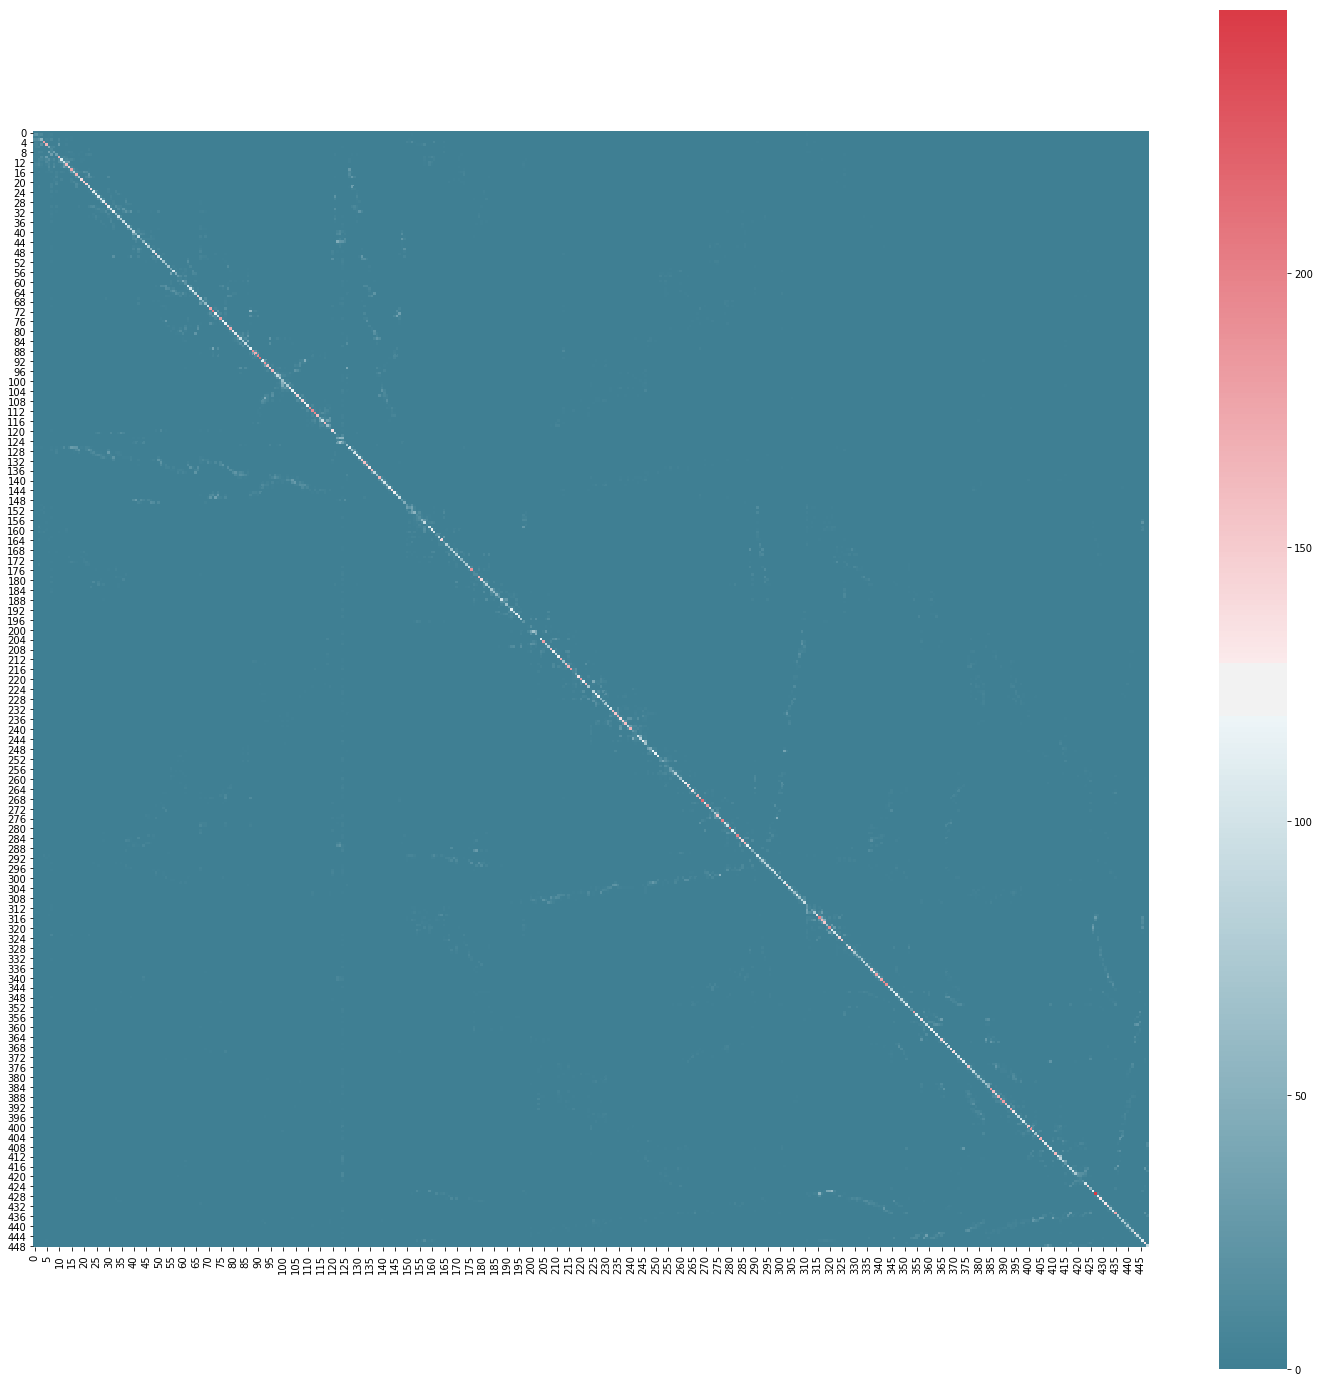

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.37      0.35      0.36        63
          3       0.04      0.44      0.07         9
          4       0.47      0.43      0.45       129
          5       0.93      0.81      0.86       226
          6       0.74      0.69      0.71       240
          7       0.34      0.67      0.45        72
          8       0.07      0.75      0.12        12
          9       0.42      0.33      0.37       101
         10       0.40      0.37      0.38        87
         11       0.71      0.69      0.70       243
         12       0.71      0.52      0.60       212
         13       0.53      0.39      0.45       241
         14       0.71      0.67      0.69       239
         15       0.68      0.59      0.63       234
         16       0.65      0.75      0.70       234
         17       0.57      0.42      0.49       203
         18       0.66      0.73      0.69   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [67]:
# Stochastic Gradient Descent on X_PCA_red_scaled_train (Data set after PCA and dimensionality reduction)

from sklearn import linear_model
clf = linear_model.SGDClassifier(loss = 'log', class_weight = 'balanced', max_iter = 20, n_jobs = 50, alpha = 0.00001)
clf.fit(X_PCA_red_scaled_train, y_train)
y_pred = clf.predict(X_PCA_red_scaled_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

Stochastic Gradient Descent is sensitive to scaling so we suspected that it will perform better on the scaled that. The scores further improved when we used PCA_transformed_scaled data. However, the results depreciated when we used the first 240 principal components to train the model.

Overall SGD performed worse than RandomForest.

### Hyperparameter tuning for SGD using Grid Search

To tune parameters for SGD we use Grid Search on a small subset of the training dataset. F1 score was given to Grid Search for optimization as F1 score considers both precision and recall.

Grid Search trains the model on different combinations of parameters and retains the best combination out of them.

A very small subset (with the same distribution as the training data set using stratified shuffle) is used to tune the hyperparameters as tuning them on the whole set takes too much time. We assume and hope that the best parameters found for this smaller set will also work for the whole dataset as they have the same distribution.

In [38]:
#Creating smaller dataset (10% of the training set) using Stratified Shuffle for Hyperparameter Optimization
sss_fs = StratifiedShuffleSplit(test_size=0.90, random_state=0)

for train_index, test_index in sss_fs.split(X_train, y_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    training_data, testing_data = train_index, test_index
    
    
X_train_fs = X_train.iloc[training_data]
y_train_fs = y_train.iloc[training_data]
print (X_train_fs.shape, y_train_fs.shape)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train_fs)
X_PCA_train_fs = pca.transform(X_train_fs)
scaler.fit(X_PCA_train_fs)  
X_PCA_scaled_train_fs = scaler.transform(X_PCA_train_fs)  

print (X_PCA_scaled_train_fs.shape)

(27475, 261) (27475,)
(27475, 261)


In [44]:
# Hyperparameter tuning for SGDClassifier via GridSearch

from sklearn import linear_model
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
sgd = linear_model.SGDClassifier(max_iter = 5) 
parameters = {'alpha': [0.0001, 0.00001, 0.000001],
              'penalty': ['l2', 'elasticnet'], 'loss': ['hinge', 'log', 'squared_hinge']} 

# GridSearch applied to optimize 'f1 score'
clf = GridSearchCV(estimator=sgd, param_grid = parameters, n_jobs=-1, cv = 3, scoring='f1_macro') 
clf.fit(X_PCA_scaled_train_fs, y_train_fs) 

print("Best f1 score:")
print(clf.best_score_)
 

print("Best parameters set found on development set:")
print(clf.best_params_)

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/sit

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.p

Best f1 score:
0.5308855333727298
Best parameters set found on development set:
{'penalty': 'elasticnet', 'loss': 'hinge', 'alpha': 1e-05}


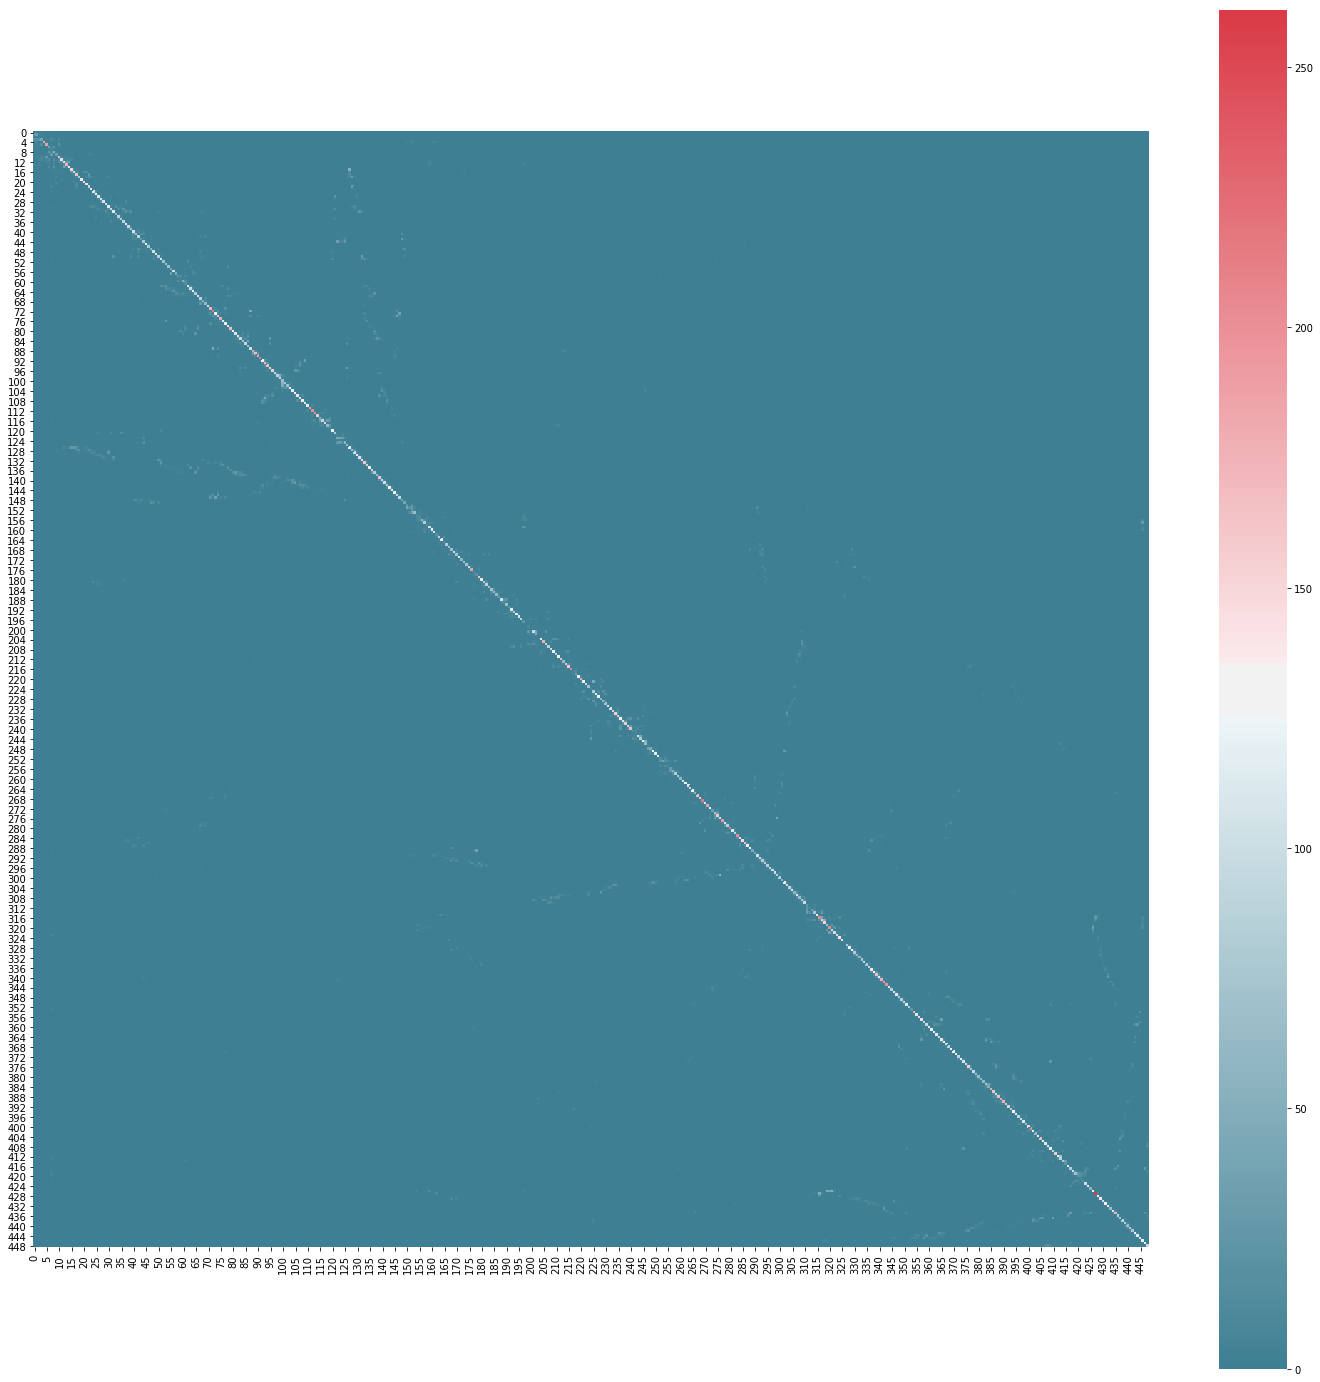

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.45      0.51      0.48        63
          3       0.04      0.33      0.07         9
          4       0.47      0.31      0.37       129
          5       0.93      0.81      0.87       226
          6       0.79      0.78      0.78       240
          7       0.34      0.51      0.41        72
          8       0.03      0.67      0.05        12
          9       0.41      0.54      0.47       101
         10       0.43      0.37      0.40        87
         11       0.72      0.72      0.72       243
         12       0.70      0.51      0.59       212
         13       0.56      0.42      0.48       241
         14       0.77      0.74      0.75       239
         15       0.67      0.59      0.63       234
         16       0.67      0.64      0.65       234
         17       0.59      0.45      0.51       203
         18       0.68      0.73      0.70   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [45]:
# Stochastic Gradient Descent on X_PCA_scaled_train using parameters obtained by grid search

from sklearn import linear_model
clf = linear_model.SGDClassifier(loss = 'hinge', penalty = 'elasticnet', class_weight = 'balanced', 
                                 max_iter = 20, n_jobs = 50, alpha = 0.00001)
clf.fit(X_PCA_scaled_train, y_train)
y_pred = clf.predict(X_PCA_scaled_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

The performance of SGD didnot change with the parameters obtained via Grid Search.

### MLP Classifier

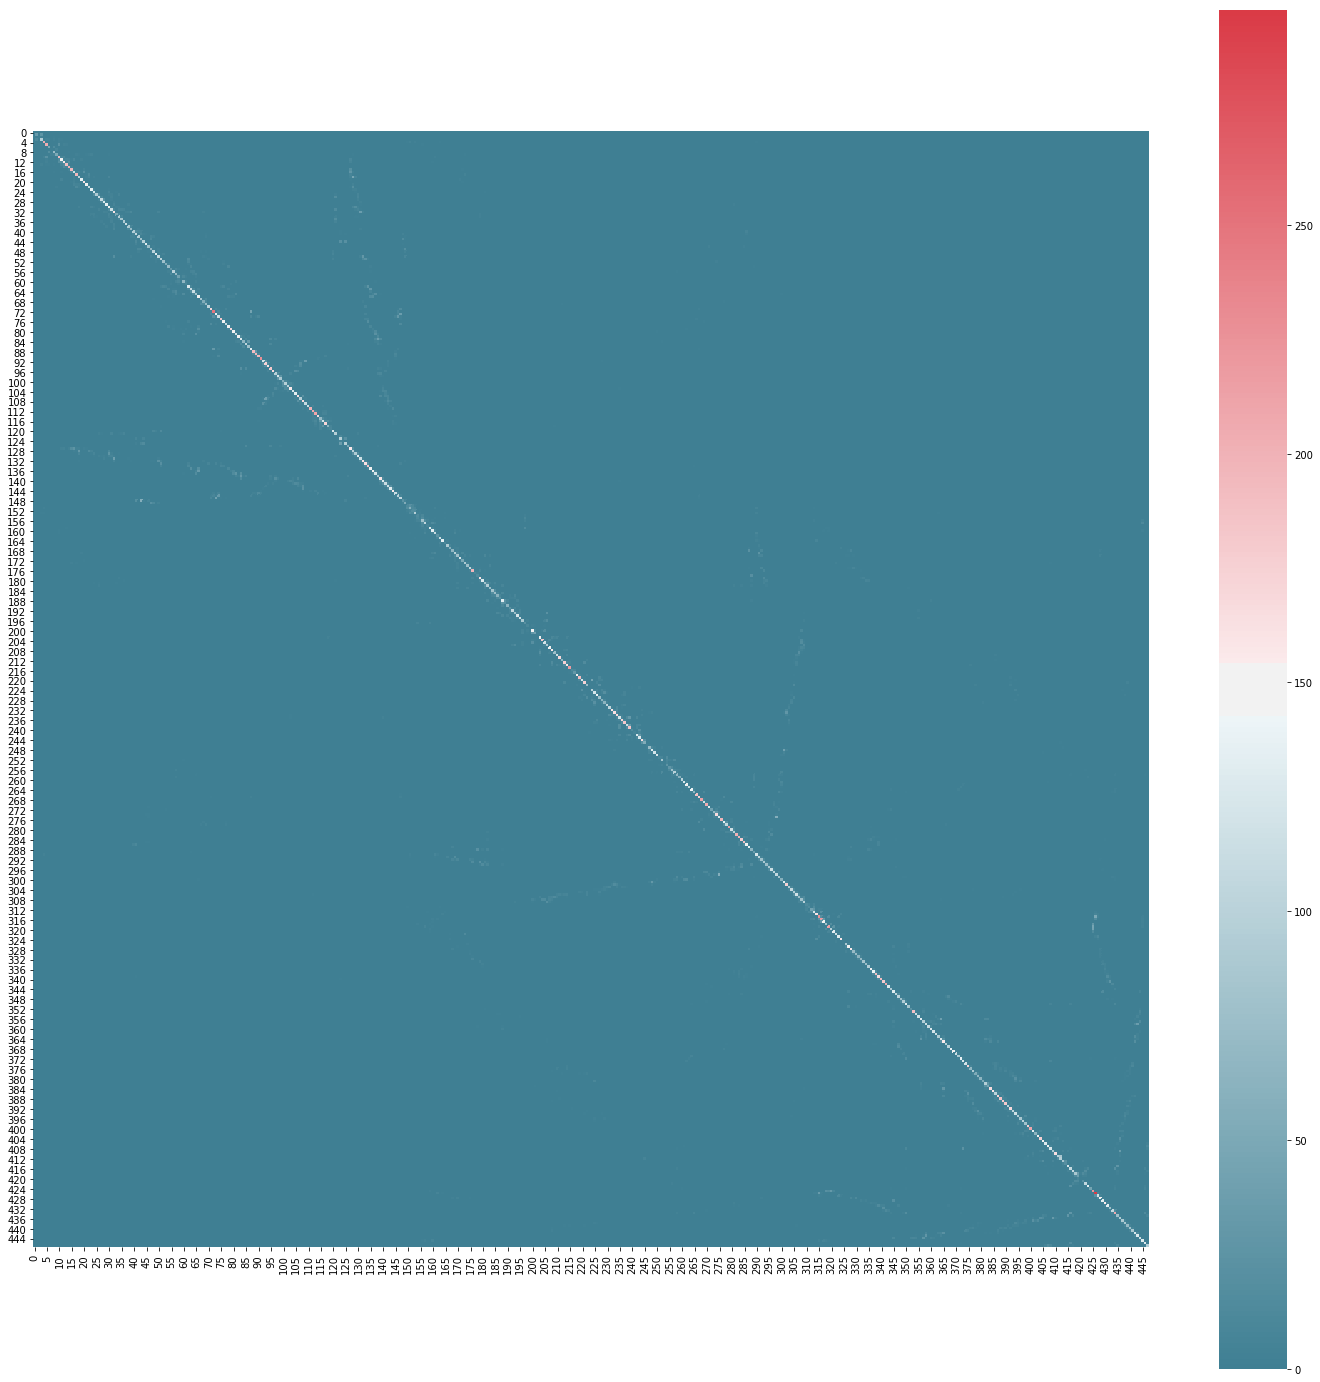

             precision    recall  f1-score   support

          1       0.00      0.00      0.00         1
          2       0.70      0.52      0.60        63
          3       0.25      0.11      0.15         9
          4       0.65      0.74      0.69       129
          5       0.92      0.91      0.92       226
          6       0.84      0.85      0.85       240
          7       0.66      0.72      0.69        72
          8       0.17      0.17      0.17        12
          9       0.68      0.72      0.70       101
         10       0.73      0.59      0.65        87
         11       0.74      0.79      0.76       243
         12       0.71      0.70      0.70       212
         13       0.73      0.66      0.70       241
         14       0.86      0.79      0.82       239
         15       0.82      0.85      0.83       234
         16       0.81      0.84      0.82       234
         17       0.62      0.57      0.59       203
         18       0.84      0.85      0.85   

/gpfs/software/x86_64/anaconda/envs/anaconda510-py35-with-jupyter_cms/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
#MLP Classifier (a neural network) applied on X_PCA_scaled_train

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = 200, max_iter = 300, random_state = 1, alpha=1e-7)
clf.fit(X_PCA_scaled_train, y_train)
y_pred = clf.predict(X_PCA_scaled_test)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
plt.figure(figsize = (25,25))
sns.heatmap(cm, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()
print(classification_report(y_test, y_pred))

Only the results for MLP trained on PCA transformed training set are retained as MLP performed worse on all other training sets. We have tuned the hyperparameters a little using brute force such that we get better results and still have a model with a reasonable convergence time.

An attempt to use Grid Search for MLP with parameter combinations from the following dictionary took too long to converge.

parameters = {'alpha': [0.00001, 0.000001, 0.0000001], 'random_state':[0,1,2,3]} 

Overall, MLP performed better than SGD but still worse than Random Forest on all three scores.


Along with the models above, we also tried some other models scikit-learn.

Quadratic Discriminant Analysis and Naive-Bayes performed poorly.

Logistic Regression, LinearSVM and kNN were left running over night without converging.

## Concluding Remarks

All in all, Random Forest Classifier with 100 trees, trained on raw data, proved to be the best classifier in our case with precision = 0.80, recall = 0.80, and F1 score = 0.79.

The second best performance was by MLP Classifier suggesting that it might be helpful to utilize better Neural Network Models from TensorFlow/ Keras for our data.

The classification reports from all the models applied show that we achieve high scores for classes which have more data and very poor scores on classes where we have a few samples. Thus, as suggested earlier, we have a class imbalance problem. One way to overcome it would be to get more data on the undersampled classes. A more data analytical approach is to generate synthetic data for the undersampled classes, for example by using Synthetic Minority Over-sampling Technique (SMOTE) available in the imblearn python library (I would have liked to apply it but I do not have rights to install any packages at the GPU I am working :)).
 

At the end I would like to thank the Minodes team for assessing my work thorougly and considering me for a place among you!